In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
def feature_scaling (x):
    x = np.array(x)
    mean = np.mean(x, axis= 0)
    std = np.std(x, axis = 0, ddof=1)
    x_scaled = (x-mean)/std
    return x_scaled, mean, std

In [4]:
def feature_mapping(x1, x2, degree):
    x1 = np.array(x1).reshape(-1,1)
    x2 = np.array(x2).reshape(-1,1)

    output = np.ones((x1.shape[0],1))

    for i in range(degree+1):
        for j in range(i+1):
            p = (x1**(i-j))*(x2**j)
            output = np.append(output, p, axis = 1)
    
    return output

In [5]:
def sigmoid(z):
    sigmoid = 1/(1+np.exp(-z))
    return sigmoid

In [6]:
def cost_reg (x, y, theta, lambda_reg):
    eps = 0.0001
    m = y.shape[0]
    h = sigmoid(x.dot(theta))
    J = (1/m) * (-y.T.dot(np.log(h + eps)) - (1-y).T.dot(np.log(1-h+eps))) + ((lambda_reg/(2*m)) * np.sum(theta[1:]**2))
    return J

In [7]:
def gradient_reg(x, y, theta, lambda_reg, iters, alpha):
    m = y.shape[0]
    J_history = np.zeros((iters,1))

    for i in range(iters):
        h = sigmoid(x.dot(theta))
        error = h - y
        gradient = ((1/m)*(error.T.dot(x))) + (lambda_reg/m * theta.T)
        gradient[0,0] = (1/m)*(error.T.dot(x[:,0]))
        theta -= alpha * gradient.T
        J_history[i] = cost_reg(x, y, theta, lambda_reg)
    
    return theta, J_history

In [8]:
def predict_all (x, theta):
    total_accuracy = [1 if sigmoid(x[i,:].dot(theta)) >= 0.5 else 0 for i in range(x.shape[0])]
    return total_accuracy

In [9]:
df = pd.read_csv('datasets/Social_Network_Ads.csv')
x_scaled, mean, std = feature_scaling(df[['Age', 'EstimatedSalary']])
y = np.array(df.Purchased.values).reshape(-1,1)

# Split data into training, dev set, and test set: 0.6, 0.2, 0.2
xtrain, xdev, ytrain, ydev = train_test_split(x_scaled, y, test_size=0.4, random_state=42)
xdev, xtest, ydev, ytest = train_test_split(xdev, ydev, test_size=0.5, random_state=42)

#All scaled dataset
x1 = x_scaled[:,0] #x1 = scaled Age data
x2 = x_scaled[:,1] #x2 = scaled EstimatedSalary data
df['Age'] = x1
df['EstimatedSalary'] = x2

#Train set 0.6
x1_train = xtrain[:,0] #x1 = scaled Age data
x2_train = xtrain[:,1] #x2 = scaled EstimatedSalary data

#Dev set 0.2
x1_dev = xdev[:,0] #x1 = scaled Age data
x2_dev = xdev[:,1] #x2 = scaled EstimatedSalary data

#Test set 0.2
x1_test = xtest[:,0] #x1 = scaled Age data
x2_test = xtest[:,1] #x2 = scaled EstimatedSalary data

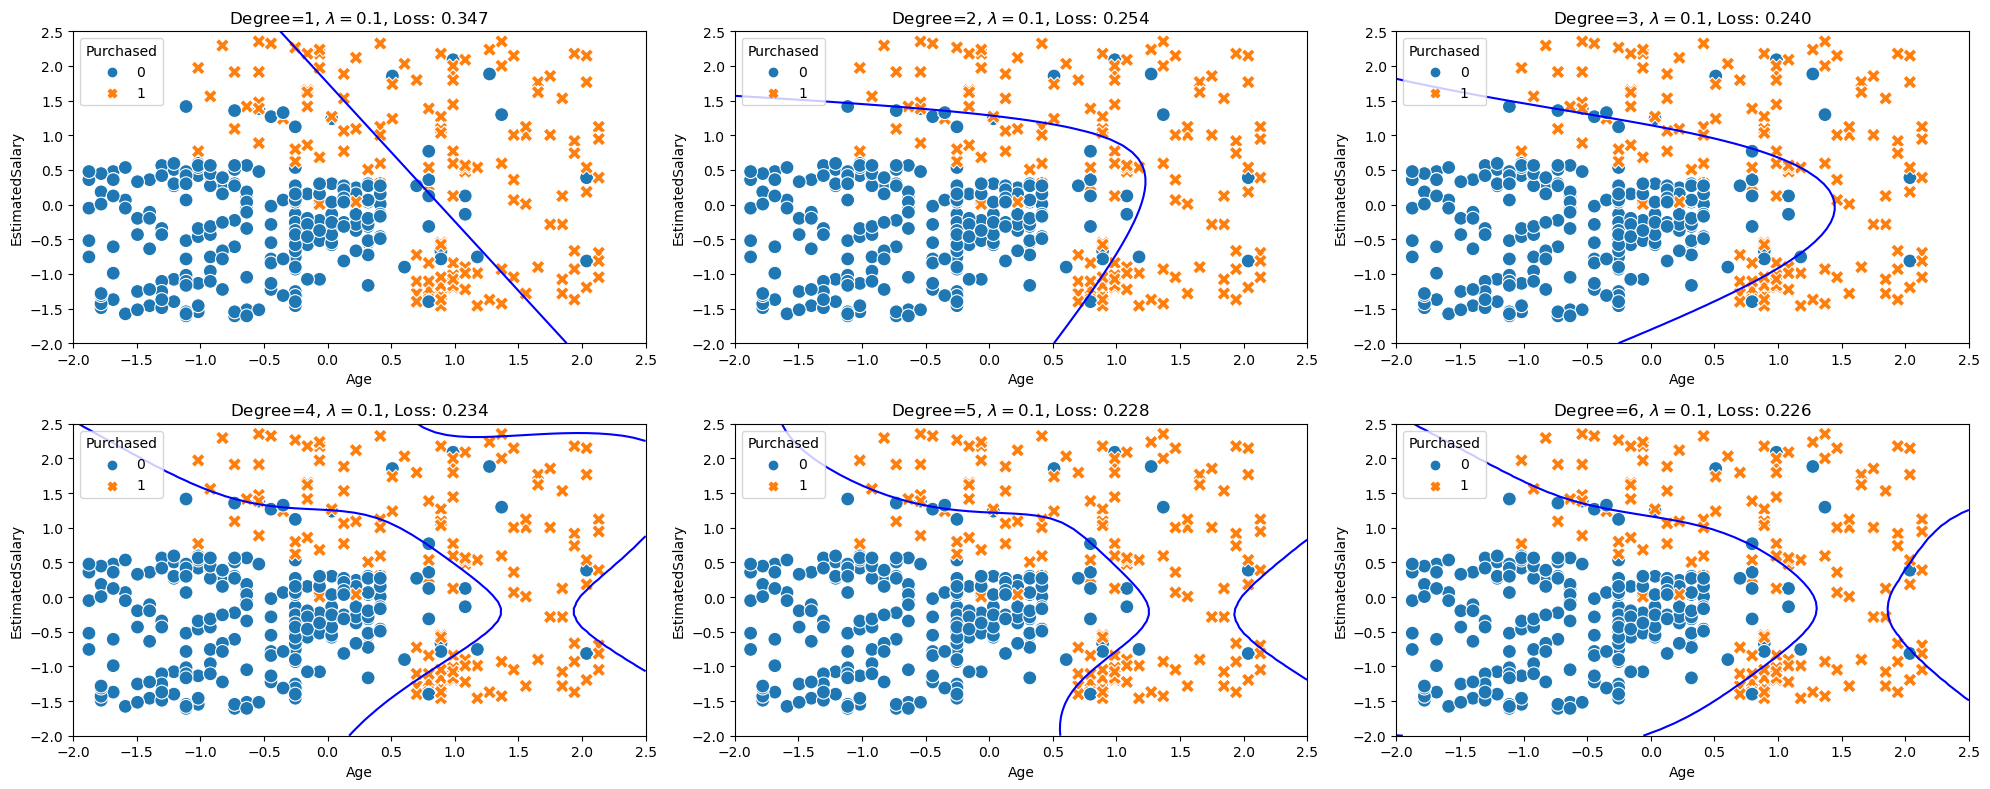

In [10]:
#Display decision boundary for different degrees.
fig, axs = plt.subplots(ncols=3,nrows=2,figsize=(20,8))

u = np.linspace(-2, 2.5, 50)
v = np.linspace(-2, 2.5, 50)
degrees = [1,2,3,4,5,6]
lambda_reg = 0.1
alpha = 0.1
iters = 2000

for i,degree in enumerate(degrees):
    xmap = feature_mapping(x1, x2, degree)
    y = np.array(df.Purchased.values).reshape(-1,1)
    initial_theta = np.zeros((xmap.shape[1],1))
    theta, cost = gradient_reg(xmap, y, initial_theta, lambda_reg, iters, alpha)
    z = np.zeros((len(u), len(v)))
    ax = axs.flatten()[i]
    for j in range(len(u)):
        for k in range(len(v)):
            z[j,k] = feature_mapping(u[j], v[k], degree).dot(theta)

    sns.scatterplot(x='Age', y='EstimatedSalary', hue='Purchased', data=df, style='Purchased', s=100, ax=ax)
    ax.contour(u, v, z.T, levels=[1], colors='blue',)
    ax.set_title(f'Degree={degree}, $\lambda={lambda_reg}$, Loss: {cost.min():.3f}')
    fig.tight_layout()
    
plt.show()


Text(0.5, 1.0, 'Train Set: Degree: 6, Lambda: 0.1, Alpha: 0.01\nTrain accuracy: 87.92%, Loss: 0.309')

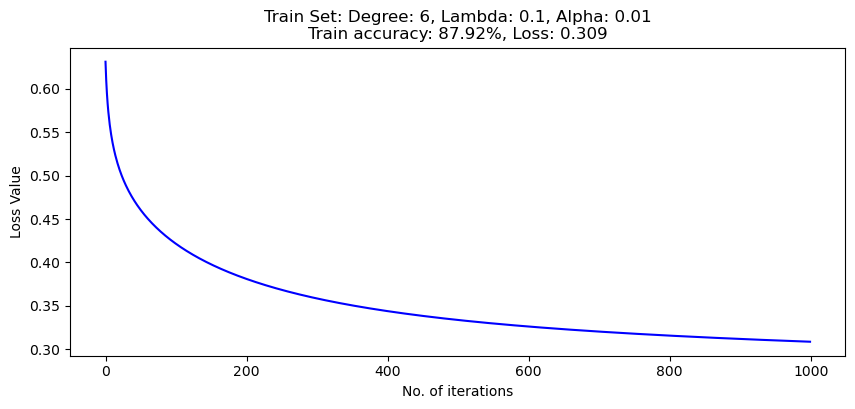

In [60]:
#Training Set. Initialize parameters. Desired Accuracy 90-95%
degree = 6
alpha = 0.01
lambda_reg = 0.1
iters = 1000

fig, ax = plt.subplots(figsize=(10,4))

x_train = feature_mapping(x1_train, x2_train, degree)
y_train = np.array(ytrain).reshape(-1,1)
theta = np.zeros(shape = (x_train.shape[1],1))

# Compute the theta and J_history for the current alpha and lambda_reg values
theta_train, J_history_train = gradient_reg(x_train, y_train, theta, lambda_reg, iters, alpha)
yhat_train = np.round(sigmoid(x_train.dot(theta)))
accuracy_train = accuracy_score(y_train, yhat_train) * 100

# Plot the loss curve in the current subplot
ax.plot(range(len(J_history_train)), J_history_train, color='b')
ax.set_xlabel('No. of iterations')
ax.set_ylabel('Loss Value')
ax.set_title(f'Train Set: Degree: {degree}, Lambda: {lambda_reg}, Alpha: {alpha}\nTrain accuracy: {accuracy_train:.2f}%, Loss: {J_history_train.min():.3f}')

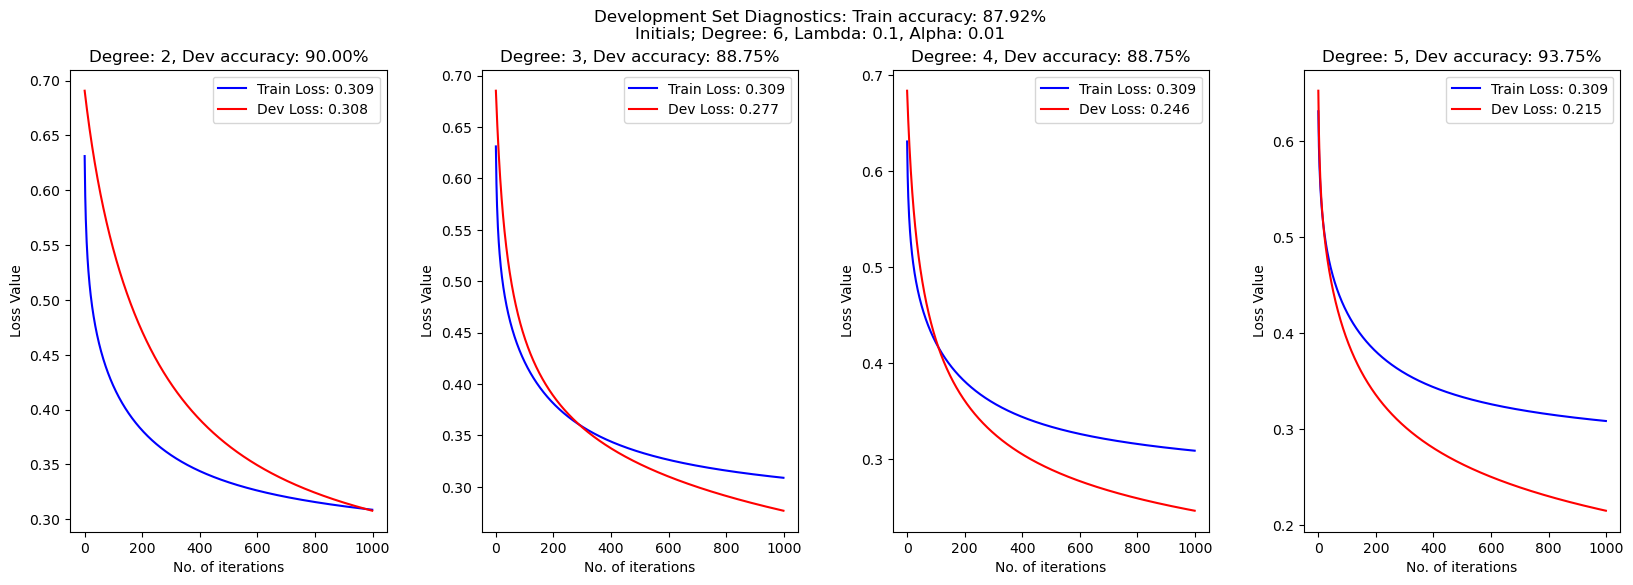

In [61]:
# Development Set. Desired Accuracy not achieve. Perform simple diagnostics for different degree values.
alpha = 0.01
lambda_reg = 0.1
degrees = [2,3,4,5]
iters = 1000

# Create a figure with 3 rows and 3 columns
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,6))

# Store all theta value
theta_all = []

# Iterate over the rows and columns of the subplot grid
for i, degree in enumerate(degrees):
    x_dev = feature_mapping(x1_dev, x2_dev, degree)
    y_dev = np.array(ydev).reshape(-1,1)
    theta = np.zeros(shape = (x_dev.shape[1],1))

    # Compute the theta and J_history for the current alpha and lambda_reg values
    theta_dev, J_history_dev = gradient_reg(x_dev, y_dev, theta, lambda_reg, iters, alpha)
    yhat_dev = np.round(sigmoid(x_dev.dot(theta_dev)))
    accuracy_dev = accuracy_score(y_dev, yhat_dev) * 100

    #Store every theta degrees.
    theta_all.append(theta_dev)

    # Plot the loss curve in the current subplot
    ax[i].plot(range(len(J_history_train)), J_history_train, color='b', label=f'Train Loss: {J_history_train.min():.3f}')
    ax[i].plot(range(len(J_history_dev)), J_history_dev, color='r', label=f'Dev Loss: {J_history_dev.min():.3f}')
    ax[i].set_xlabel('No. of iterations')
    ax[i].set_ylabel('Loss Value')
    ax[i].set_title(f'Degree: {degree}, Dev accuracy: {accuracy_dev:.2f}%')
    ax[i].legend()

# Add a title to the entire figure
fig.suptitle(f'Development Set Diagnostics: Train accuracy: {accuracy_train:.2f}%\nInitials; Degree: 6, Lambda: 0.1, Alpha: 0.01')

# Adjust the spacing between the subplots
plt.subplots_adjust(hspace=0.5, wspace=0.3)

# Display the figure
plt.show()

In [62]:
# Test set. Desired accuracy achieved. Model generalized well :)
x_test = feature_mapping(x1_test, x2_test, 2)
y_test = np.array(ytest).reshape(-1,1)
yhat_test = np.round(sigmoid(x_test.dot(theta_all[0])))
accuracy_test = accuracy_score(y_test, yhat_test) * 100
print(f'Test set accuracy: {accuracy_test:.2f}%')

Test set accuracy: 95.00%
